In [1]:
import os
import random
from typing import Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import TBXLoggerCallback
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.policy import Policy
from ray.rllib.utils.typing import AgentID, EnvType, PolicyID
import seaborn as sns
import torch

from stocktradingv2.agent.mydqn import MyDQNConfig, MyDQN
from stocktradingv2.env.SingleStockTradingEnv import SingleStockTradingEnv

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init()

2023-03-14 10:02:13,387	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
SEED = 114

TEST_START_DAY = '2017-01-01'
TRADE_START_DAY = '2020-01-01'

In [4]:
dfs = []
for root, dirs, files in os.walk("./datasets/CSI300/"):
    for file in files:
        path = os.path.join("./datasets/CSI300/", file)
        df = pd.read_csv(path)
        dfs.append((file, df))

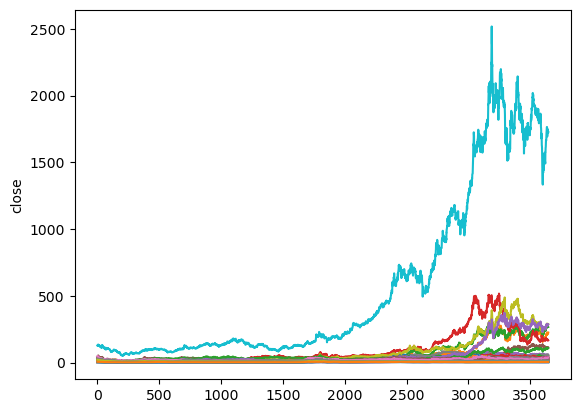

In [5]:
for tic, df in dfs:
    df.rename(columns={"close_": "close", "close": "close_"}, inplace=True)
    #print(np.log(df.close.iloc[-1]/df.close.iloc[0]))
    sns.lineplot(df.close)

In [6]:
test_start = pd.to_datetime(TEST_START_DAY, format='%Y-%m-%d')
trade_start = pd.to_datetime(TRADE_START_DAY, format='%Y-%m-%d')

dfs_train = []
dfs_test = []
dfs_trade = []
for tic, df in dfs:
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df_train = df.loc[df.date < test_start].sort_index(ascending=True).copy()
    df_test = df.loc[(df.date >= test_start) & (df.date < trade_start)].sort_index(ascending=True).copy()
    df_trade = df.loc[df.date >= trade_start].sort_index(ascending=True).copy()
    dfs_train.append(df_train)
    dfs_test.append(df_test)
    dfs_trade.append(df_trade)

In [11]:
class MyCallbacks(DefaultCallbacks):
    def __init__(self, legacy_callbacks_dict: Dict[str, callable] = None):
        self._eval_counter = 0
        self._train_counter = 0
        self.df_idx = 0
        super().__init__(legacy_callbacks_dict)

    # @OverrideToImplementCustomLogic
    # def on_sub_environment_created(
    #     self,
    #     *,
    #     worker: "RolloutWorker",
    #     sub_environment: EnvType,
    #     env_context: EnvContext,
    #     env_index: Optional[int] = None,
    #     **kwargs,
    # ) -> None:
    #     """Callback run when a new sub-environment has been created.

    #     This method gets called after each sub-environment (usually a
    #     gym.Env) has been created, validated (RLlib built-in validation
    #     + possible custom validation function implemented by overriding
    #     `Algorithm.validate_env()`), wrapped (e.g. video-wrapper), and seeded.

    #     Args:
    #         worker: Reference to the current rollout worker.
    #         sub_environment: The sub-environment instance that has been
    #             created. This is usually a gym.Env object.
    #         env_context: The `EnvContext` object that has been passed to
    #             the env's constructor.
    #         kwargs: Forward compatibility placeholder.
    #     """
    #     pass
    #  worker.worker_index
    # large batch size

    def on_episode_created(
        self,
        *,
        worker: "RolloutWorker",
        base_env: BaseEnv,
        policies: Dict[PolicyID, Policy],
        env_index: int,
        episode: Union[Episode, EpisodeV2],
        **kwargs,
    ) -> None:
        """Callback run when a new episode is created (but has not started yet!).

        This method gets called after a new Episode(V2) instance is created to
        start a new episode. This happens before the respective sub-environment's
        (usually a gym.Env) `reset()` is called by RLlib.

        1) Episode(V2) created: This callback fires.
        2) Respective sub-environment (gym.Env) is `reset()`.
        3) Callback `on_episode_start` is fired.
        4) Stepping through sub-environment/episode commences.

        Args:
            worker: Reference to the current rollout worker.
            base_env: BaseEnv running the episode. The underlying
                sub environment objects can be retrieved by calling
                `base_env.get_sub_environments()`.
            policies: Mapping of policy id to policy objects. In single
                agent mode there will only be a single "default" policy.
            env_index: The index of the sub-environment that is about to be reset
                (within the vector of sub-environments of the BaseEnv).
            episode: The newly created episode. This is the one that will be started
                with the upcoming reset. Only after the reset call, the
                `on_episode_start` event will be triggered.
            kwargs: Forward compatibility placeholder.
        """
        env = base_env.get_sub_environments()[env_index]
        env.df = env._dfs[self.df_idx]
        self.df_idx = (self.df_idx + 1) % env.num_df

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: EpisodeV2,
        env_index: int,
        **kwargs
    ):
        env = base_env.get_sub_environments()[env_index]

        if env._last_total_trading > 0:
            episode.custom_metrics["total_trading"] = env._last_total_trading
            episode.custom_metrics["success_rate"] = env._last_success_trade / env._last_total_trading
            episode.custom_metrics["log-ret"] = np.log(env._last_asset_memory[-1] / env._last_asset_memory[0])
            # episode.hist_data["action_memory"] = env.action_memory
            # episode.hist_data["asset_memory"] = env.asset_memory

        _plot = False
        if _plot:
            df = pd.DataFrame(
                data={
                "date": env.date,
                "prices": env.prices,
                "action": [1] + env.action_memory,
                "asset": env.asset_memory
                }
            )
            df.loc[df.action == 1, "action"] = np.nan
            fig, ax = plt.subplots()
            sns.lineplot(x=df.date, y=df.prices, ax=ax)
            # plot buying action
            sns.scatterplot(
                x=df.date[df.action == 0], 
                y=df.prices[df.action == 0],  
                markers="^", 
                ax=ax
            )
            # plot selling action
            sns.scatterplot(
                x=df.date[df.action == 2], 
                y=df.prices[df.action == 2], 
                markers="v",
                ax=ax
            )

            in_eval =  worker.policy_config["in_evaluation"]
            dqn_type = worker.policy_config["model"]["custom_model_config"] ["type"]
            df_num = len(env._dfs)
            if in_eval:
                fig.savefig(f"./eval_df{df_num}_{self._eval_counter}_{episode.episode_id:05d}.png")
                self._eval_counter += 1
            else:
                if self._train_counter % 10 == 0:
                    fig.savefig(f"./train_df{df_num}_{self._train_counter}_{episode.episode_id:05d}.png")
                self._train_counter += 1

In [12]:
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)

In [13]:
param_space = {
    "framework": "torch",
    "lr": tune.grid_search([5e-3, 5e-2]),

    "env": "SingleStockTrading",
    "disable_env_checking": True,
    "env_config": {
        "df": dfs_train,
        "num_df": 25,
        #"seed": SEED,
        #"shuffle": True,
    },

    "num_workers": 0,
    "num_gpus": 0.25,
    "num_envs_per_worker": 10,
    "num_cpus_per_worker": 5,

    "model": {
        "custom_model_config": {
            "type": "dqn", # tune.grid_search(["dqn", "iqn", "qrdqn", "cqn"]) ,
            "vmin": -10,
            "vmax": 10,
            "lstm_dim": 64,
            "net_arch": [64, 64],
            "action_mask_fn": SingleStockTradingEnv.action_mask_fn,
            "num_atoms": 50,
            "cos_embedding_dim": 64,
            "risk_distortion_measure": None,
        }
    },
    #"seed": 114,
    "training_intensity": 25, # 25
    "train_batch_size": 512,
    #"min_sample_timesteps_per_iteration": 64,
    "min_train_timesteps_per_iteration": 64,
    
    "exploration_config": {
            "type": "EpsilonGreedy",
            "initial_epsilon": 1.0,
            "final_epsilon": 0.02,
            "epsilon_timesteps": 10000,
    },
    "callbacks": MyCallbacks,

    # "evaluation_interval": 10,
    # "evaluation_duration": len(dfs_test),
    # "evaluation_duration_unit": "episodes",
    # "evaluation_num_workers": 1,
    # "evaluation_config": {
    #     "explore": False,
    #     "env_config": {
    #         "df": dfs_test,
    #         "num": len(dfs_test),
    #     },
    # }
}

In [ ]:
tuner = tune.Tuner(
    MyDQN, 
    param_space=param_space,
    tune_config=tune.TuneConfig(num_samples=1),
    run_config=air.RunConfig(
        name="MyDQN_25dfs_multienv_study_on_batch_size",
        progress_reporter=JupyterNotebookReporter(),
        stop={
            "episode_reward_mean": 10,
            "timesteps_total": 2500000,
        },
        callbacks=[TBXLoggerCallback()],
    )
)
results = tuner.fit()

In [39]:
results[0].checkpoint

Checkpoint(local_path=C:\Users\Wu Lingfeng\ray_results\MyDQN_2023-03-11_17-54-04\MyDQN_SingleStockTrading_a8457_00000_0_type=dqn_2023-03-11_17-54-04\checkpoint_000079)

In [ ]:
result = results.get_best_result(metric="episode_reward_mean", mode="max")
cp = result.best_checkpoints[0][0]
algo = MyDQN.from_checkpoint(cp)

<AxesSubplot: ylabel='close'>

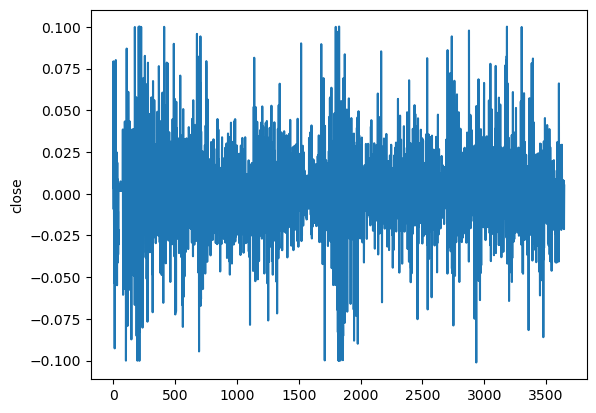

In [15]:
df = dfs[0][1]
pct_c = df.close.pct_change(1)
sns.lineplot(pct_c)

<AxesSubplot: xlabel='close', ylabel='Count'>

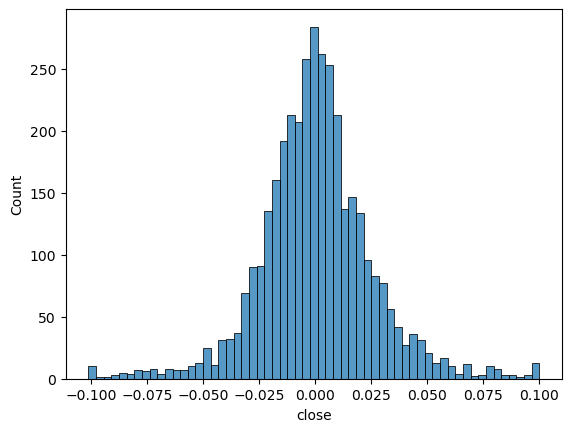

In [16]:
sns.histplot(pct_c)

<AxesSubplot: ylabel='close'>

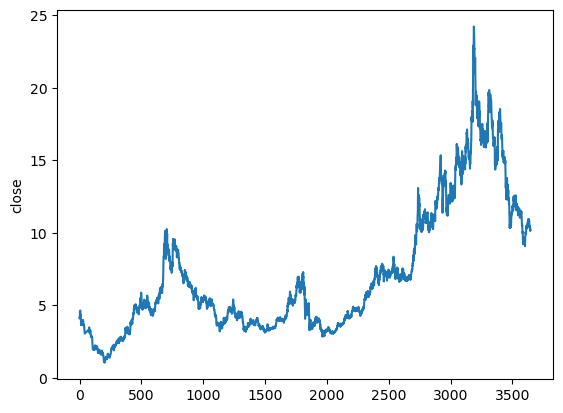

In [27]:
sns.lineplot(df.close)

In [20]:
def ema(data: np.array, encof: int) -> np.array:
    encof = int(encof)
    assert data.ndim == 1
    assert encof > 0, f"Invalid encof {encof}"

    alpha = 2 / (1 + encof)
    beta = 1 - alpha
    beta_pow = beta ** np.arange(data.shape[0])[::-1]
    encof = beta_pow * alpha
    encof[0] /= alpha
    assert np.abs(np.sum(encof) - 1) < 1e-5, encof
    ema = np.cumsum(encof * data) / beta_pow
    return ema


C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_12120\4227066611.py:12: RuntimeWarning: invalid value encountered in divide
  ema = np.cumsum(encof * data) / beta_pow
C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_12120\4227066611.py:12: RuntimeWarning: invalid value encountered in divide
  ema = np.cumsum(encof * data) / beta_pow
C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_12120\186634003.py:9: RuntimeWarning: divide by zero encountered in divide
  pct_c = np.diff(data) / data[1:]
C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_12120\186634003.py:9: RuntimeWarning: invalid value encountered in divide
  pct_c = np.diff(data) / data[1:]


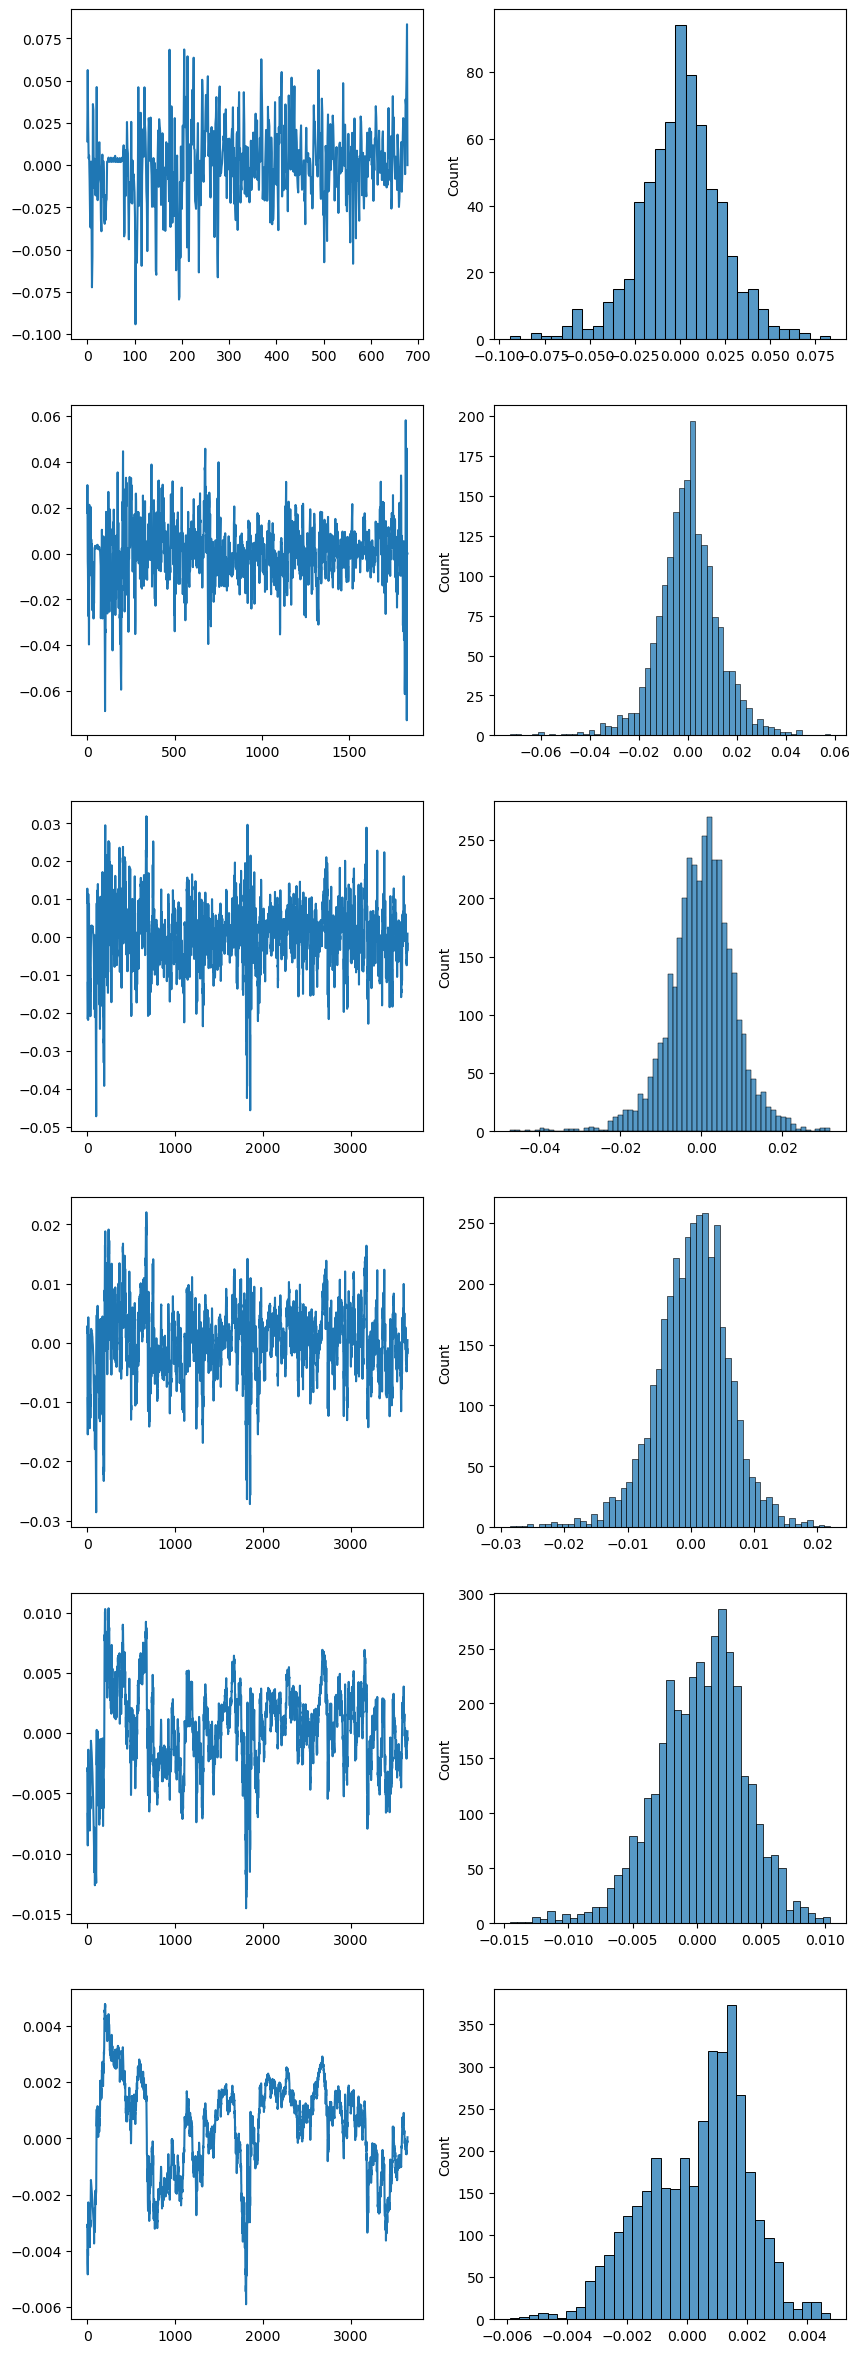

In [26]:
window_list = [2, 5, 10, 20, 60, 250]
fig, ax = plt.subplots(len(window_list), 2, figsize=(10, 30))

for i, w in enumerate(window_list):
    data = df.close.to_numpy()
    data = data[::-1]
    data = ema(data, w)
    data = data[::-1]
    pct_c = np.diff(data) / data[1:]
    pct_c[pct_c == -1] = 0
    
    sns.lineplot(pct_c, ax=ax[i][0])
    sns.histplot(pct_c, ax=ax[i][1])

In [15]:
from torch.distributions.dirichlet import Dirichlet

In [62]:
dist = Dirichlet(torch.tensor([1e5, 0.5]))

In [80]:
dist.rsample()

tensor([1.0000e+00, 3.8813e-06])